### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов.

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/runnerup96/pytorch-machine-translation

Ноутбук с результатами выкладывать на ваш **google диск** курса.

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский.

In [1]:
!wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip

--2024-05-27 20:19:46--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16305013 (16M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  15.55M  50.7MB/s    in 0.3s    

2024-05-27 20:19:47 (50.7 MB/s) - ‘rus-eng.zip’ saved [16305013/16305013]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


In [2]:
with open("/content/rus.txt", mode="r", encoding="utf-8") as f:
            lines = f.read().strip().split("\n")

In [3]:
lines[10].split("\t")[:2]

['Run!', 'Бегите!']

In [4]:
import re
from tqdm import tqdm

def preprocess_texts(text):
    text = text.lower()
    text = re.sub(r"([.!?])", r" \1", text)
    text = re.sub(r"[^a-zA-Zа-яйёьъА-Яй]+", r" ", text)
    return text.strip()

def read_dataset(filepath):
        with open(filepath, mode="r", encoding="utf-8") as f:
            lines = f.read().strip().split("\n")

        translations = []
        for line in tqdm(lines, desc="Collecting pairs"):
            pair = tuple(map(preprocess_texts, line.split("\t")[:2]))
            translations.append(pair)

        return translations

translations = read_dataset("rus.txt")
translations_short = list(filter(lambda x: max(len(x[0].split(" ")), len(x[1].split(" "))) <= 15, translations))
print("Num of translations with len <= 15:", len(translations_short))

Num of translations with len <= 15: 494101


In [5]:
#split data
import random
from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(translations_short, test_size=0.1, random_state=42)

### BPE encoding


In [6]:
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.decoders import BPEDecoder
from tokenizers.processors import TemplateProcessing
from tokenizers import Tokenizer

def train_tokenizer(texts, special_tokens, vocab_size=3000, max_len=15):
    tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = BpeTrainer(vocab_size=vocab_size, special_tokens=special_tokens)
    tokenizer.train_from_iterator(texts, trainer)
    tokenizer.post_processor = TemplateProcessing(
        single="[BOS] $A [EOS]",
        special_tokens = [
            ("[BOS]", tokenizer.token_to_id("[BOS]")),
            ("[EOS]", tokenizer.token_to_id("[EOS]"))
        ],
    )
    tokenizer.decoder = BPEDecoder()
    tokenizer.max_len=max_len
    return tokenizer


In [7]:
sp_tokens = ["[BOS]", "[PAD]", "[EOS]", "[UNK]", "[MASK]"]

train_src = [t[0] for t in train_pairs]
train_tgt = [t[1] for t in train_pairs]
src_tokenizer = train_tokenizer(train_src, special_tokens=sp_tokens)
tgt_tokenizer = train_tokenizer(train_tgt, special_tokens=sp_tokens)

BOS_IDX, PAD_IDX, EOS_IDX = 0, 1, 2

In [8]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 500):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 312,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [9]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [40]:
from transformers import get_linear_schedule_with_warmup
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.manual_seed(0)

SRC_VOCAB_SIZE = src_tokenizer.get_vocab_size()
TGT_VOCAB_SIZE = tgt_tokenizer.get_vocab_size()
EMB_SIZE = 312
NHEAD = 8
FFN_HID_DIM = 312
BATCH_SIZE = 1024
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 5

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(torch.tensor(src_tokenizer.encode(src_sample).ids))
        tgt_batch.append(torch.tensor(tgt_tokenizer.encode(tgt_sample).ids))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
train_dataloader = DataLoader(train_pairs, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(test_pairs, batch_size=BATCH_SIZE, collate_fn=collate_fn)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=4000, num_training_steps=NUM_EPOCHS * len(train_dataloader))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [41]:
def train_epoch(model, train_dataloader, optimizer):
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        scheduler.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model, val_dataloader):
    model.eval()
    losses = 0

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [42]:
import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.data.metrics import bleu_score


def calculate_bleu(data_loader, model, src_tokenizer, tgt_tokenizer):
    model.eval()
    targets = []
    outputs = []

    with torch.no_grad():
        for src, tgt in tqdm(data_loader):
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            tgt_input = tgt[:-1, :]

            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

            tgt_out = tgt[1:, :]
            predicted_ids = logits.argmax(2)
            predicted_sentences = [[tgt_tokenizer.decode([p]) for p in pred.tolist()] for pred in predicted_ids.transpose(0, 1)]
            target_sentences = [[tgt_tokenizer.decode([t]) for t in tgt.tolist()] for tgt in tgt_out.transpose(0, 1)]
            #print(predicted_sentences)
            #print(target_sentences)
            outputs.extend(predicted_sentences)
            targets.extend([[t] for t in target_sentences])
            #break

    return bleu_score(outputs, targets)

In [43]:
from timeit import default_timer as timer

train_loss_history = []
val_loss_history = []
bleu_scores = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, train_dataloader, optimizer)
    train_loss_history.append(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer, val_dataloader)
    val_loss_history.append(val_loss)
    bleu = calculate_bleu(val_dataloader, transformer, src_tokenizer, tgt_tokenizer)
    bleu_scores.append(bleu)
    print(f'Epoch [{epoch}/{NUM_EPOCHS+1}], Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, BLEU: {bleu:.3f}')


100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


Epoch [1/6], Train Loss: 7.350, Val Loss: 6.512, BLEU: 0.731


100%|██████████| 49/49 [00:15<00:00,  3.09it/s]


Epoch [2/6], Train Loss: 6.024, Val Loss: 5.518, BLEU: 0.736


100%|██████████| 49/49 [00:16<00:00,  3.05it/s]


Epoch [3/6], Train Loss: 5.279, Val Loss: 4.855, BLEU: 0.740


100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Epoch [4/6], Train Loss: 4.690, Val Loss: 4.253, BLEU: 0.751


100%|██████████| 49/49 [00:16<00:00,  2.89it/s]


Epoch [5/6], Train Loss: 4.149, Val Loss: 3.705, BLEU: 0.760


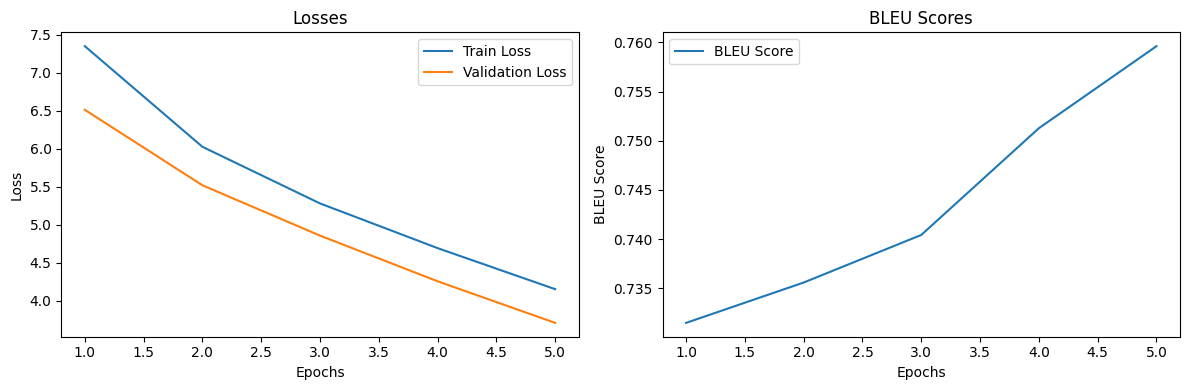

In [44]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, bleu_scores, label='BLEU Score')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores')
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = torch.tensor(src_tokenizer.encode(src_sentence).ids).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join([tgt_tokenizer.decode([t]) for t in list(tgt_tokens.cpu().numpy())]).replace("[BOS]", "").replace("[EOS]", "")

In [46]:
import numpy as np
sample = np.random.choice(range(len(test_pairs)), 10)
for i in sample:
    print("Source:", test_pairs[i][0])
    print("Ground truth:", test_pairs[i][1])
    print("Translation:", translate(transformer, test_pairs[i][0]))
    print("-----")

Source: the girl was afraid to jump down from the roof
Ground truth: девочка боялась прыгнуть вниз с крыши
Translation:  собака был очень по французски с ним на ко р 
-----
Source: which one did tom give you that one
Ground truth: какой том тебе дал тот
Translation:  сколько том тебе это сделал 
-----
Source: tom s horse is a lot faster than mine
Ground truth: лошадь тома намного быстрее моей
Translation:  у тома есть много денег 
-----
Source: every rule has its exceptions
Ground truth: у каждого правила есть свои исключения
Translation:  у нас есть есть про ди е у него есть 
-----
Source: i told tom i was going to australia
Ground truth: я сказал тому что еду в австралию
Translation:  я сказал тому что я был в австралии 
-----
Source: tom lent thirty dollars to me yesterday
Ground truth: том одолжил мне вчера тридцать долларов
Translation:  том любит меня на меня на меня вчера 
-----
Source: tom is stronger than i am
Ground truth: том сильнее меня
Translation:  том сделал меня 
-----